# Pembuatan model multi-variabel

In [1]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

import numpy as np
import matplotlib.pyplot as plt
# plt.style.use(['science', 'notebook', 'grid'])
plt.style.use(['science', 'no-latex'])

# import seaborn as sns; sns.set(font_scale=1.5)
import scipy.special
import pandas as pd
import pymc as pm
import arviz as az
# az.style.use("arviz-darkgrid")
import corner

import aesara
import aesara.tensor as at
from aesara.compile.ops import as_op

# plt.figure(figsize=(15,5))

In [2]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

In [3]:
# @as_op(itypes=[tt.dvector, tt.dscalar, tt.dscalar, tt.dscalar], otypes=[tt.dvector])

def diffract(t, t0, A, v):
    cc, ss = scipy.special.fresnel(v*(t-t0))
    y = A*0.5*((cc + 0.5)**2 + (ss + 0.5)**2)
    return y

In [4]:
A_true = 100.
t0_true = 0.
v_true = 1.0
σ_true = 10.

x_data = np.linspace(-5, 5, 500)

np.random.seed(0)

y_data = diffract(x_data, t0_true, A_true, v_true)
y_data = np.random.normal(y_data, scale=σ_true)

y_data_scaled = y_data / (y_data.std() * 2)

A_true_scaled = A_true / (y_data.std() * 2)
t0_true_scaled = t0_true / (y_data.std() * 2)
σ_true_scaled = σ_true / (y_data.std() * 2)
v_true_scaled = v_true / (y_data.std() * 2)
# y_data_scaled = standardize(y_data)
# A_true_scaled = standardize(A_true)
# t0_true_scaled = standardize(t0_true)
# v_true_scaled = standardize(v_true)
# σ_true_scaled = standardize(σ_true)

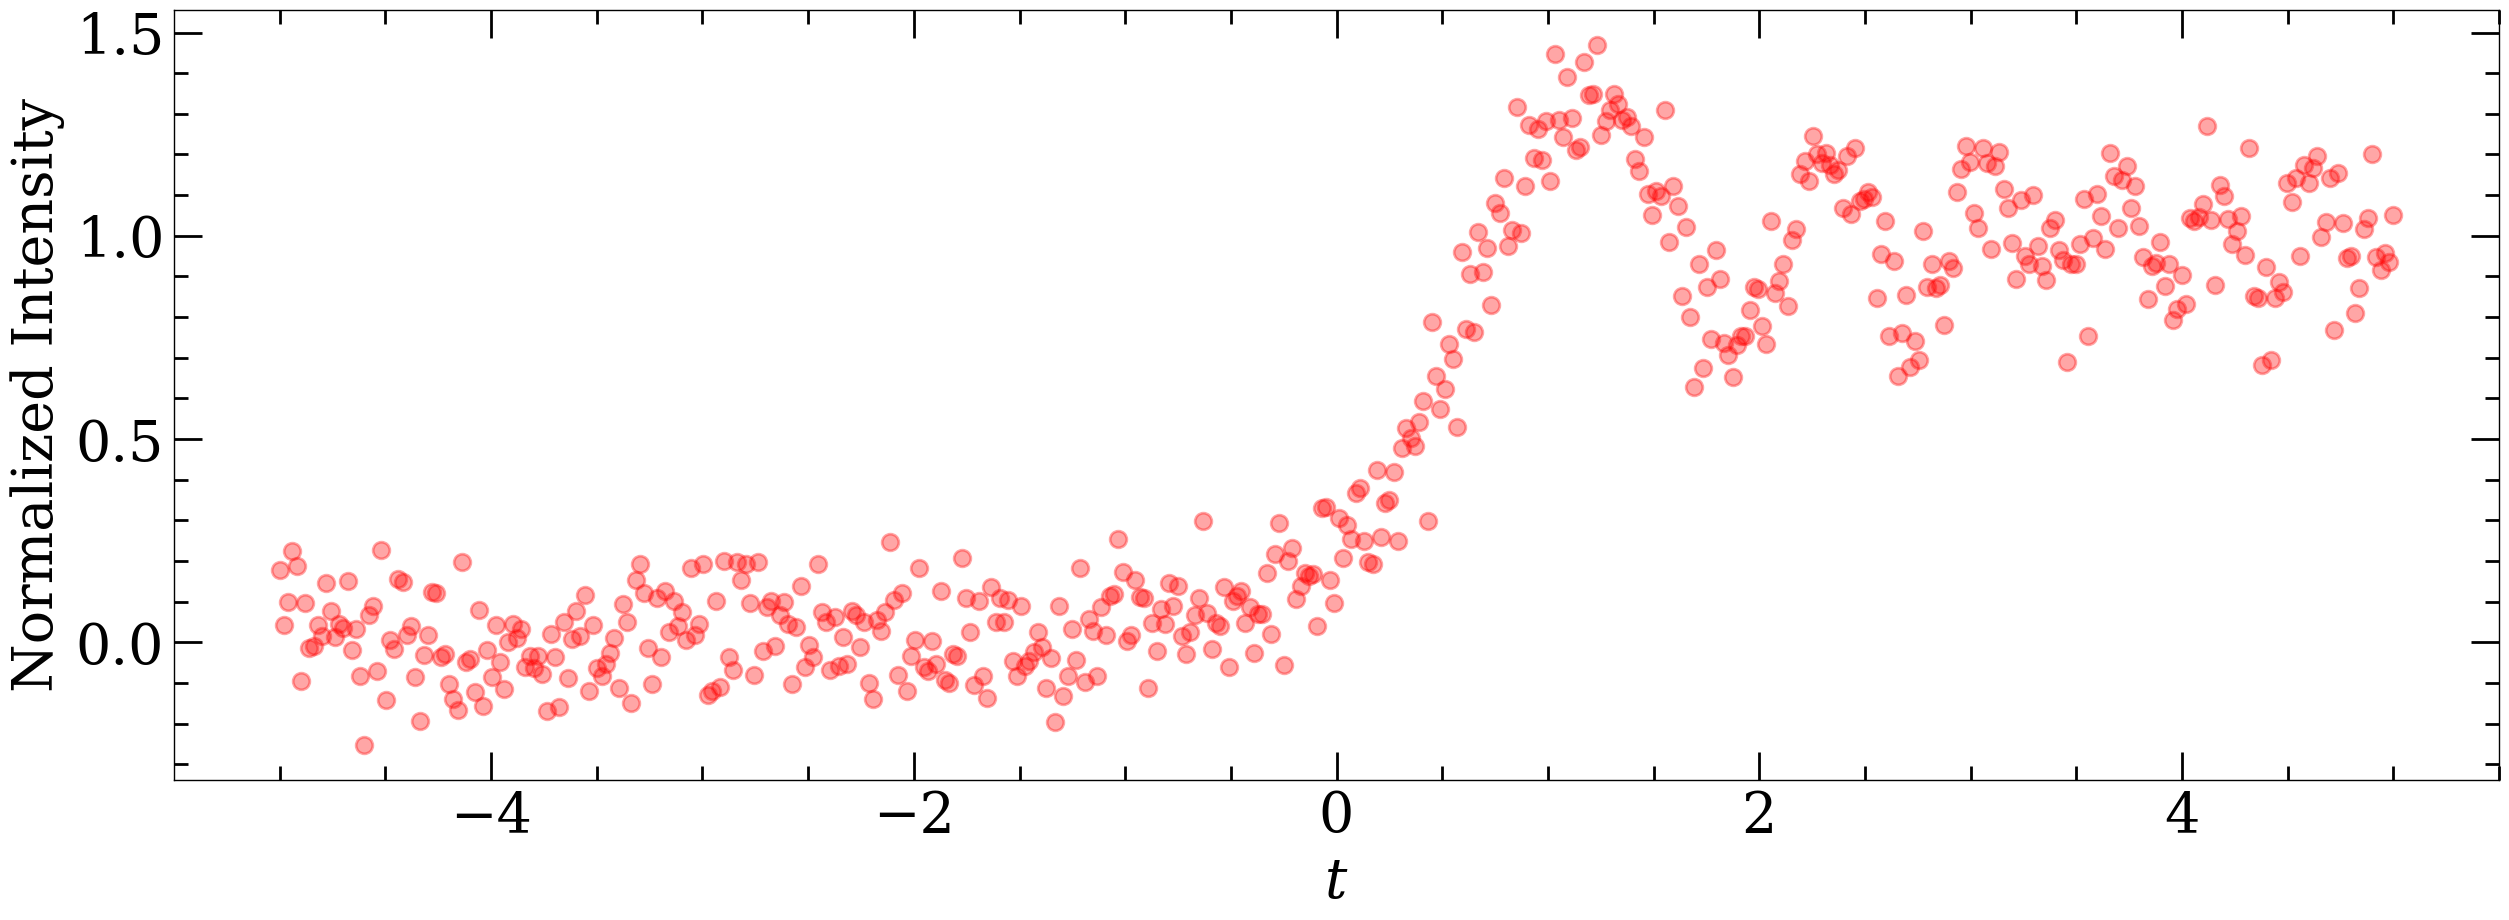

In [5]:
plt.figure(figsize = (15,5), facecolor='w')
plt.scatter(x_data, y_data_scaled, c='r', marker='o', alpha=0.35)
# plt.plot(x_data, y_data, c='r', alpha=0.5)
plt.xlabel(r'$t$', fontsize=20)
plt.ylabel('Normalized Intensity', fontsize=20)
plt.tick_params('both', length=10, width=1, which='major', labelsize=20)
plt.tick_params('both', length=5, width=1, which='minor', labelsize=20)
# plt.rc('font', size=20)
plt.savefig('syn-data-mono-plot.pdf', format='pdf')

In [6]:
y_data_scaled.std()

0.5

---

## Catatan terkait *Theano decorator* (<span style="color:red">pada `PyMC4` digantikan oleh `aesara`</span>)
Diambil dari: https://docs.pymc.io/en/v3/pymc-examples/examples/getting_started.html?highlight=arbitrary%20deterministic#Arbitrary-deterministics

![](as_op.png)

<!-- ![image.png](attachment:dc2da0d5-fade-42d4-a908-5adf311389e3.png) -->

Untuk bisa menggunakan fungsi `Scipy` pada `PyMC3`, maka fungsi tersebut harus dibungkus dalam `Theano` dengan decorator `@as_op`. Opsi lain adalah menulis ulang fungsi yang diinginkan dalam `Theano`.
**Catatan**: `Theano` sudah tidak lagi dikembangkan, diambil alih oleh `PyMC` developer sebagai `Theano - PyMC` / `aesara` (https://github.com/aesara-devs/aesara).

https://discourse.pymc.io/t/use-of-scipy-functions-in-pymc3/1621

![](aesara_function.png)
<!-- ![image.png](attachment:2746bc68-a30d-48d5-b1b1-367ed031ea26.png) -->

---

### <span style="color:red">Gunakan *syntax* `aesara` </span>

In [7]:
# Fungsi Aesara dalam bentuk pure-python. Dijadikan input dalam pembuatan model PyMC
# -----------------------------------------------------------------------------------
@as_op(itypes=[at.dvector, at.dscalar, at.dscalar, at.dscalar], otypes=[at.dvector])
def t_diffract(t, t0, A, v):
    cc, ss = scipy.special.fresnel(v*(t-t0))
    y = A*0.5*((cc + 0.5)**2 + (ss + 0.5)**2)
    return y

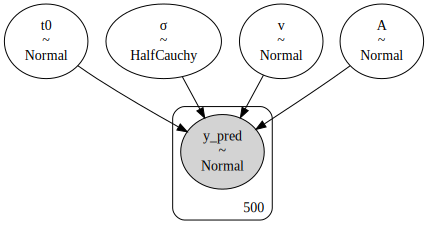

In [8]:
# Karena fungsinya diberi decorator as_op dari Aesara, maka inputnya mesti kompatibel dengan Aesara
# -------------------------------------------------------------------------------------------------
t_shared = aesara.shared(x_data)
t0_shared = aesara.shared(t0_true)
v_shared = aesara.shared(v_true)


with pm.Model() as model_fresnel:
    amp = pm.Normal('A', mu=1., sigma=0.5)
    σ = pm.HalfCauchy('σ', beta=5.)
    t0 = pm.Normal('t0', mu=0., sigma=0.5)
    v = pm.Normal('v', mu=0., sigma=0.5)
    
    mu = t_diffract(t_shared, t0, amp, v) # model-nya (expected value)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=σ, observed=y_data_scaled) # likelihood-nya

pm.model_to_graphviz(model_fresnel)

In [9]:
with model_fresnel:
    prior = pm.sample_prior_predictive()

Sampling: [A, t0, v, y_pred, σ]


In [10]:
with model_fresnel:
    idata = pm.sample(2500, tune=1000, cores=1)
    # idata = pm.sample(2500, tune=1000, step=pm.Metropolis, cores=1)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Slice: [A]
>>Slice: [t0]
>>Slice: [v]
>NUTS: [σ]


Sampling 2 chains for 1_000 tune and 2_500 draw iterations (2_000 + 5_000 draws total) took 24 seconds.
Sampling: [y_pred]


In [11]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A,0.987,0.007,0.975,1.000,0.0,0.0,4390.0,3775.0,1.0
t0,-0.001,0.013,-0.023,0.026,0.0,0.0,735.0,997.0,1.0
v,1.002,0.004,0.993,1.010,0.0,0.0,722.0,1021.0,1.0
σ,0.099,0.003,0.094,0.105,0.0,0.0,2467.0,2860.0,1.0


In [12]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

array([<AxesSubplot: title={'center': 'A'}>,
       <AxesSubplot: title={'center': 't0'}>,
       <AxesSubplot: title={'center': 'v'}>,
       <AxesSubplot: title={'center': 'σ'}>], dtype=object)

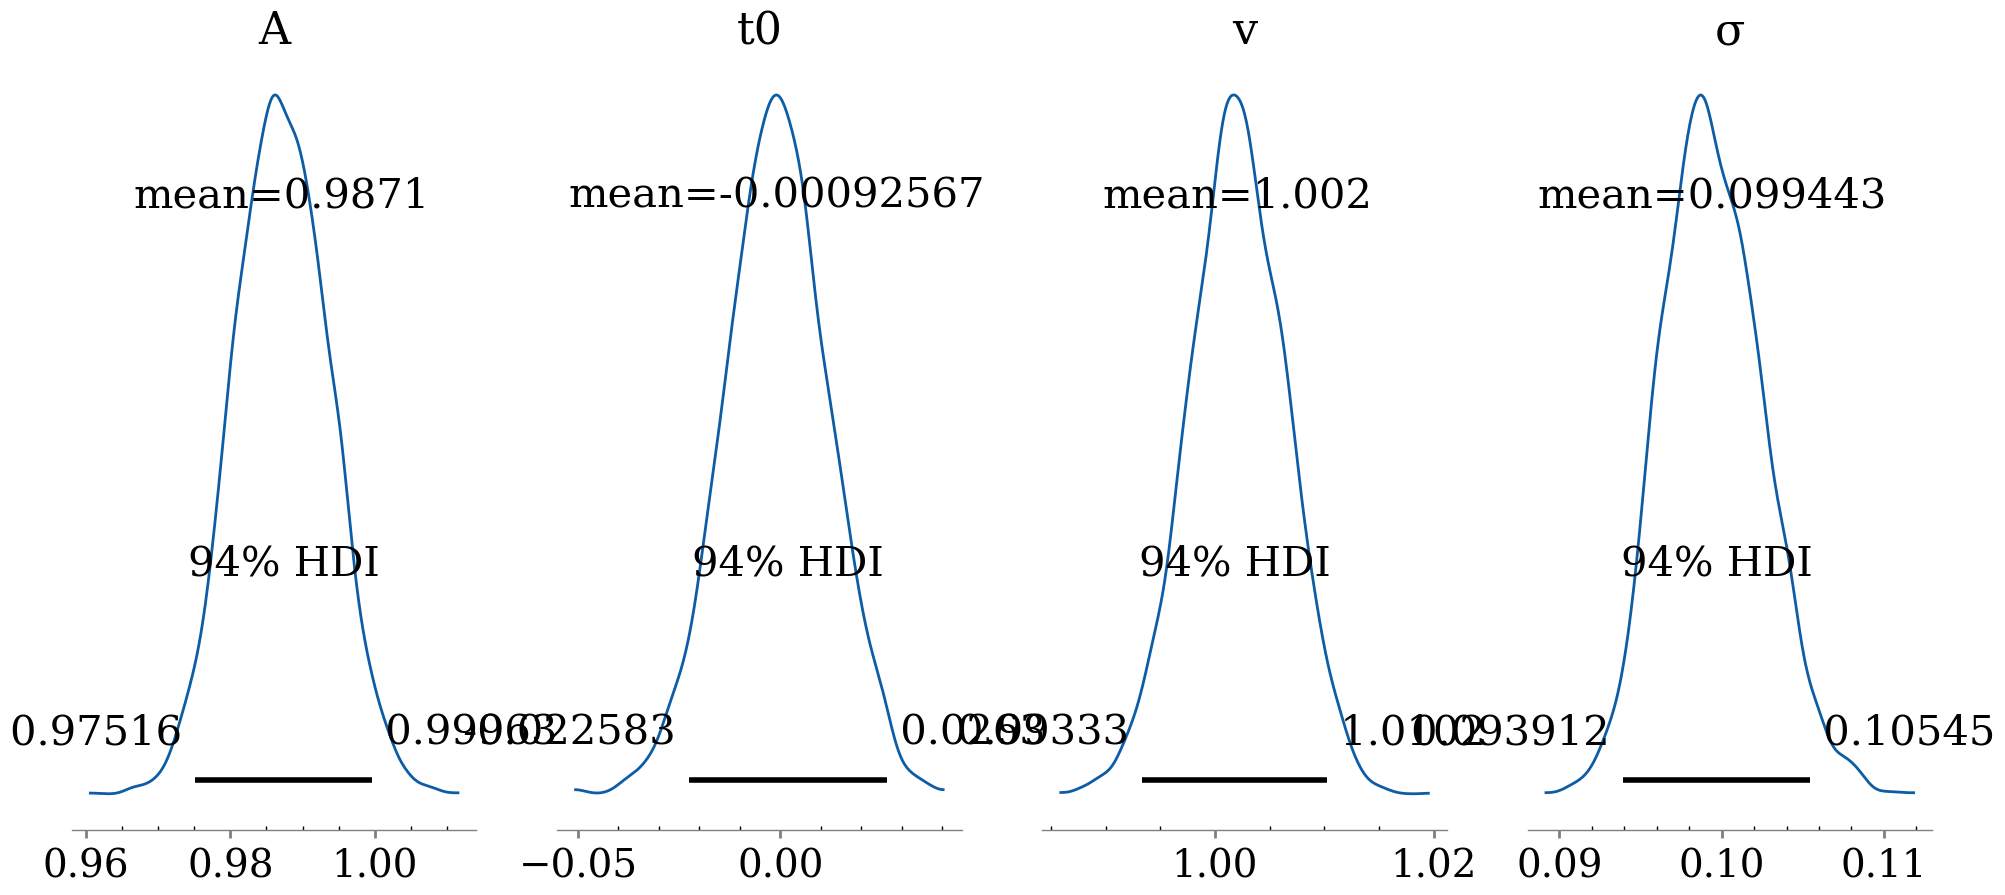

In [13]:
# pm.plot_posterior(idata, var_names=None, round_to=5, figsize = (12,5))
pm.plot_posterior(idata, var_names=None, round_to=5, figsize = (12,5))

In [14]:
idata_pp = idata.posterior_predictive

idata_pp_st = idata_pp.stack(sample=("chain", "draw"))

crit_l = np.percentile(idata_pp_st['y_pred'], 2.5, axis=1)  # 2.5% persentil 
crit_u = np.percentile(idata_pp_st['y_pred'], 97.5, axis=1)  # 97.5% persentil
mean_spp = np.mean(idata_pp_st['y_pred'], axis=1) # Median

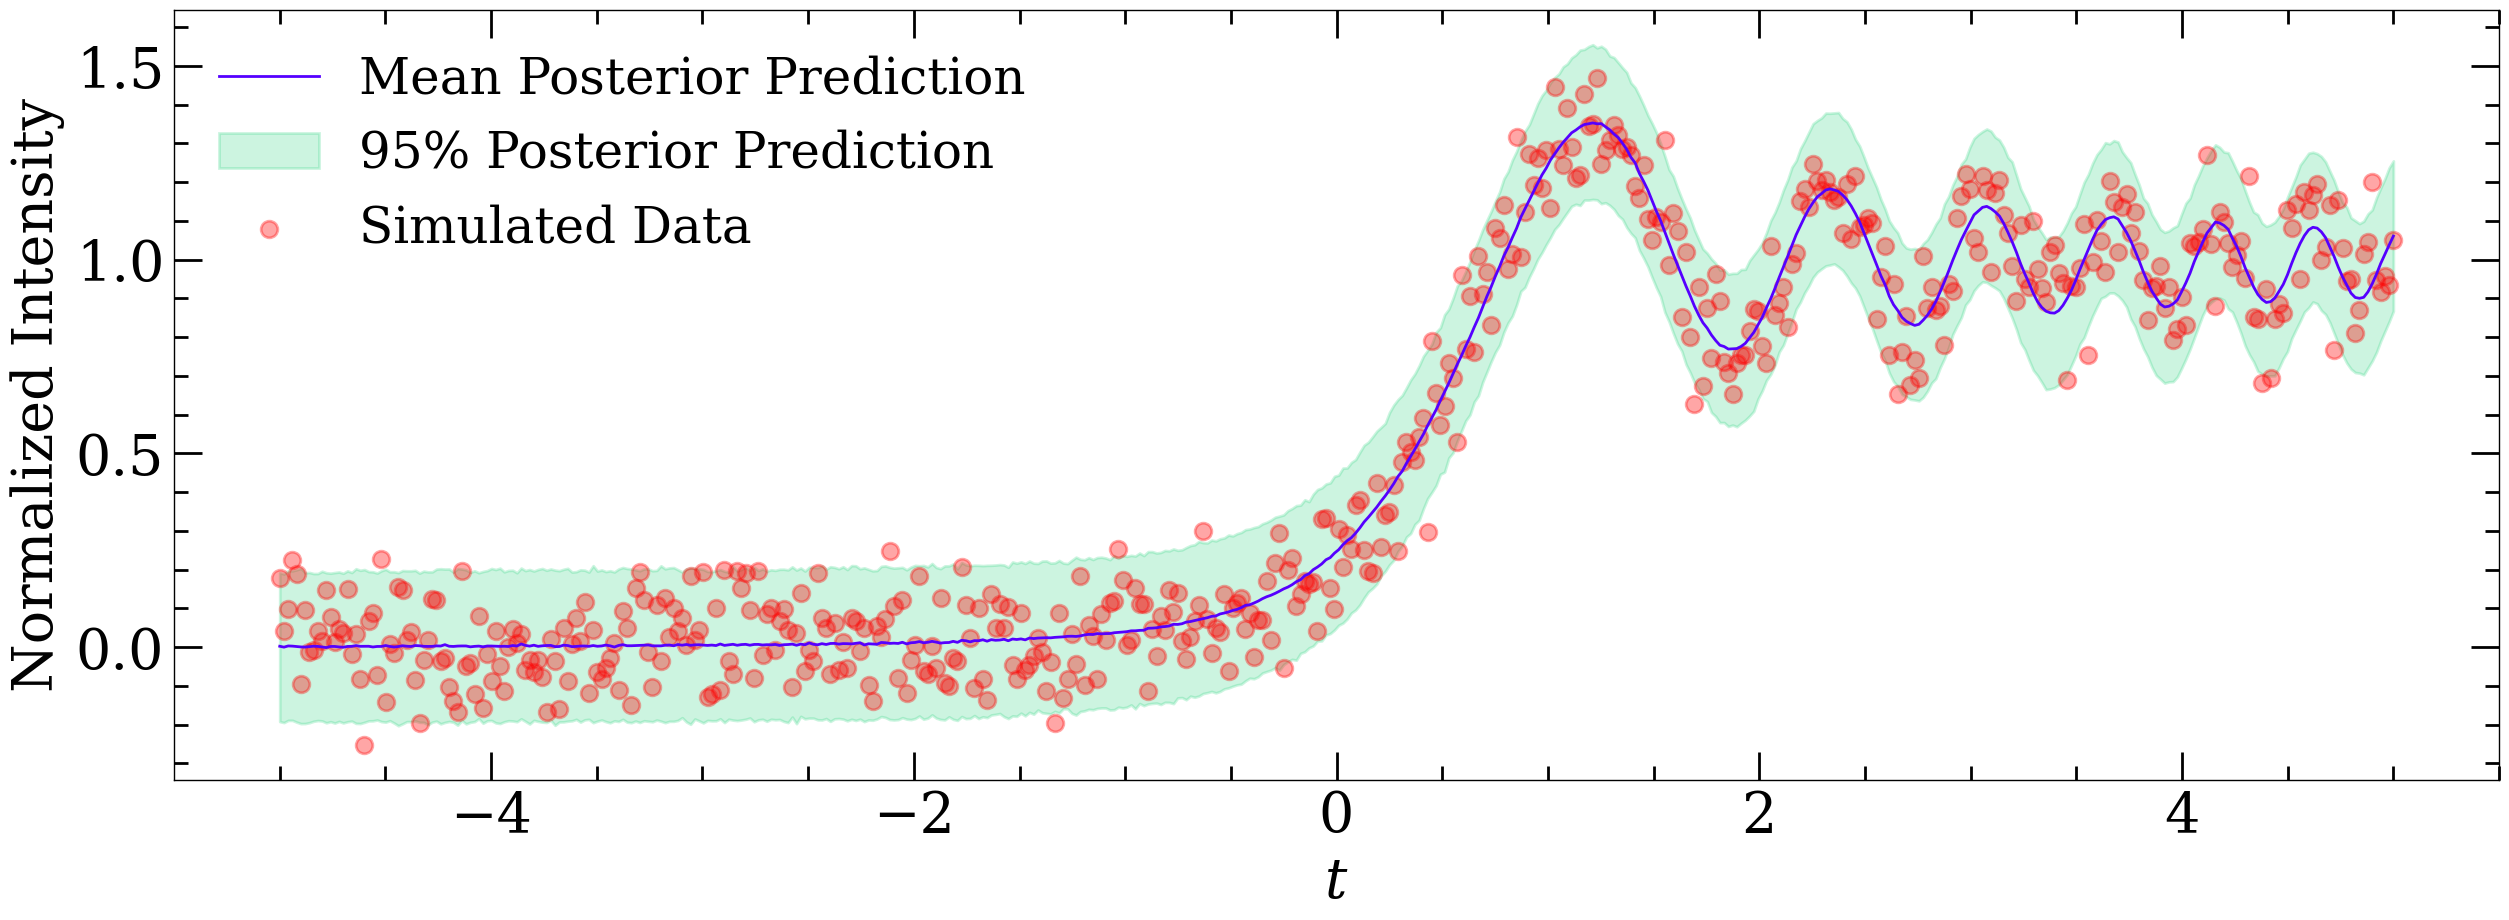

In [16]:
# with sns.plotting_context('talk', font_scale=1.2):
#     _, ax = plt.subplots(figsize=(14,6 ))
plt.figure(figsize=(15,5))
plt.plot(x_data, mean_spp, linestyle='-', linewidth=1, color="#5500ff")
plt.fill_between(x_data, crit_l, crit_u, alpha=0.2, color="#00cc66")
plt.scatter(x_data, y_data_scaled, c='r', marker='o', alpha=0.35)
# plt.plot(x_data, y_data, c='r', alpha=0.3)
plt.xlabel(r'$t$', fontsize=20)
plt.ylabel('Normalized Intensity', fontsize=20)
plt.tick_params('both', length=10, width=1, which='major', labelsize=20)
plt.tick_params('both', length=5, width=1, which='minor', labelsize=20)

plt.legend(['Mean Posterior Prediction', '95% Posterior Prediction', 'Simulated Data'], fontsize=18)

plt.savefig('model-mono-fit.pdf')

In [17]:
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

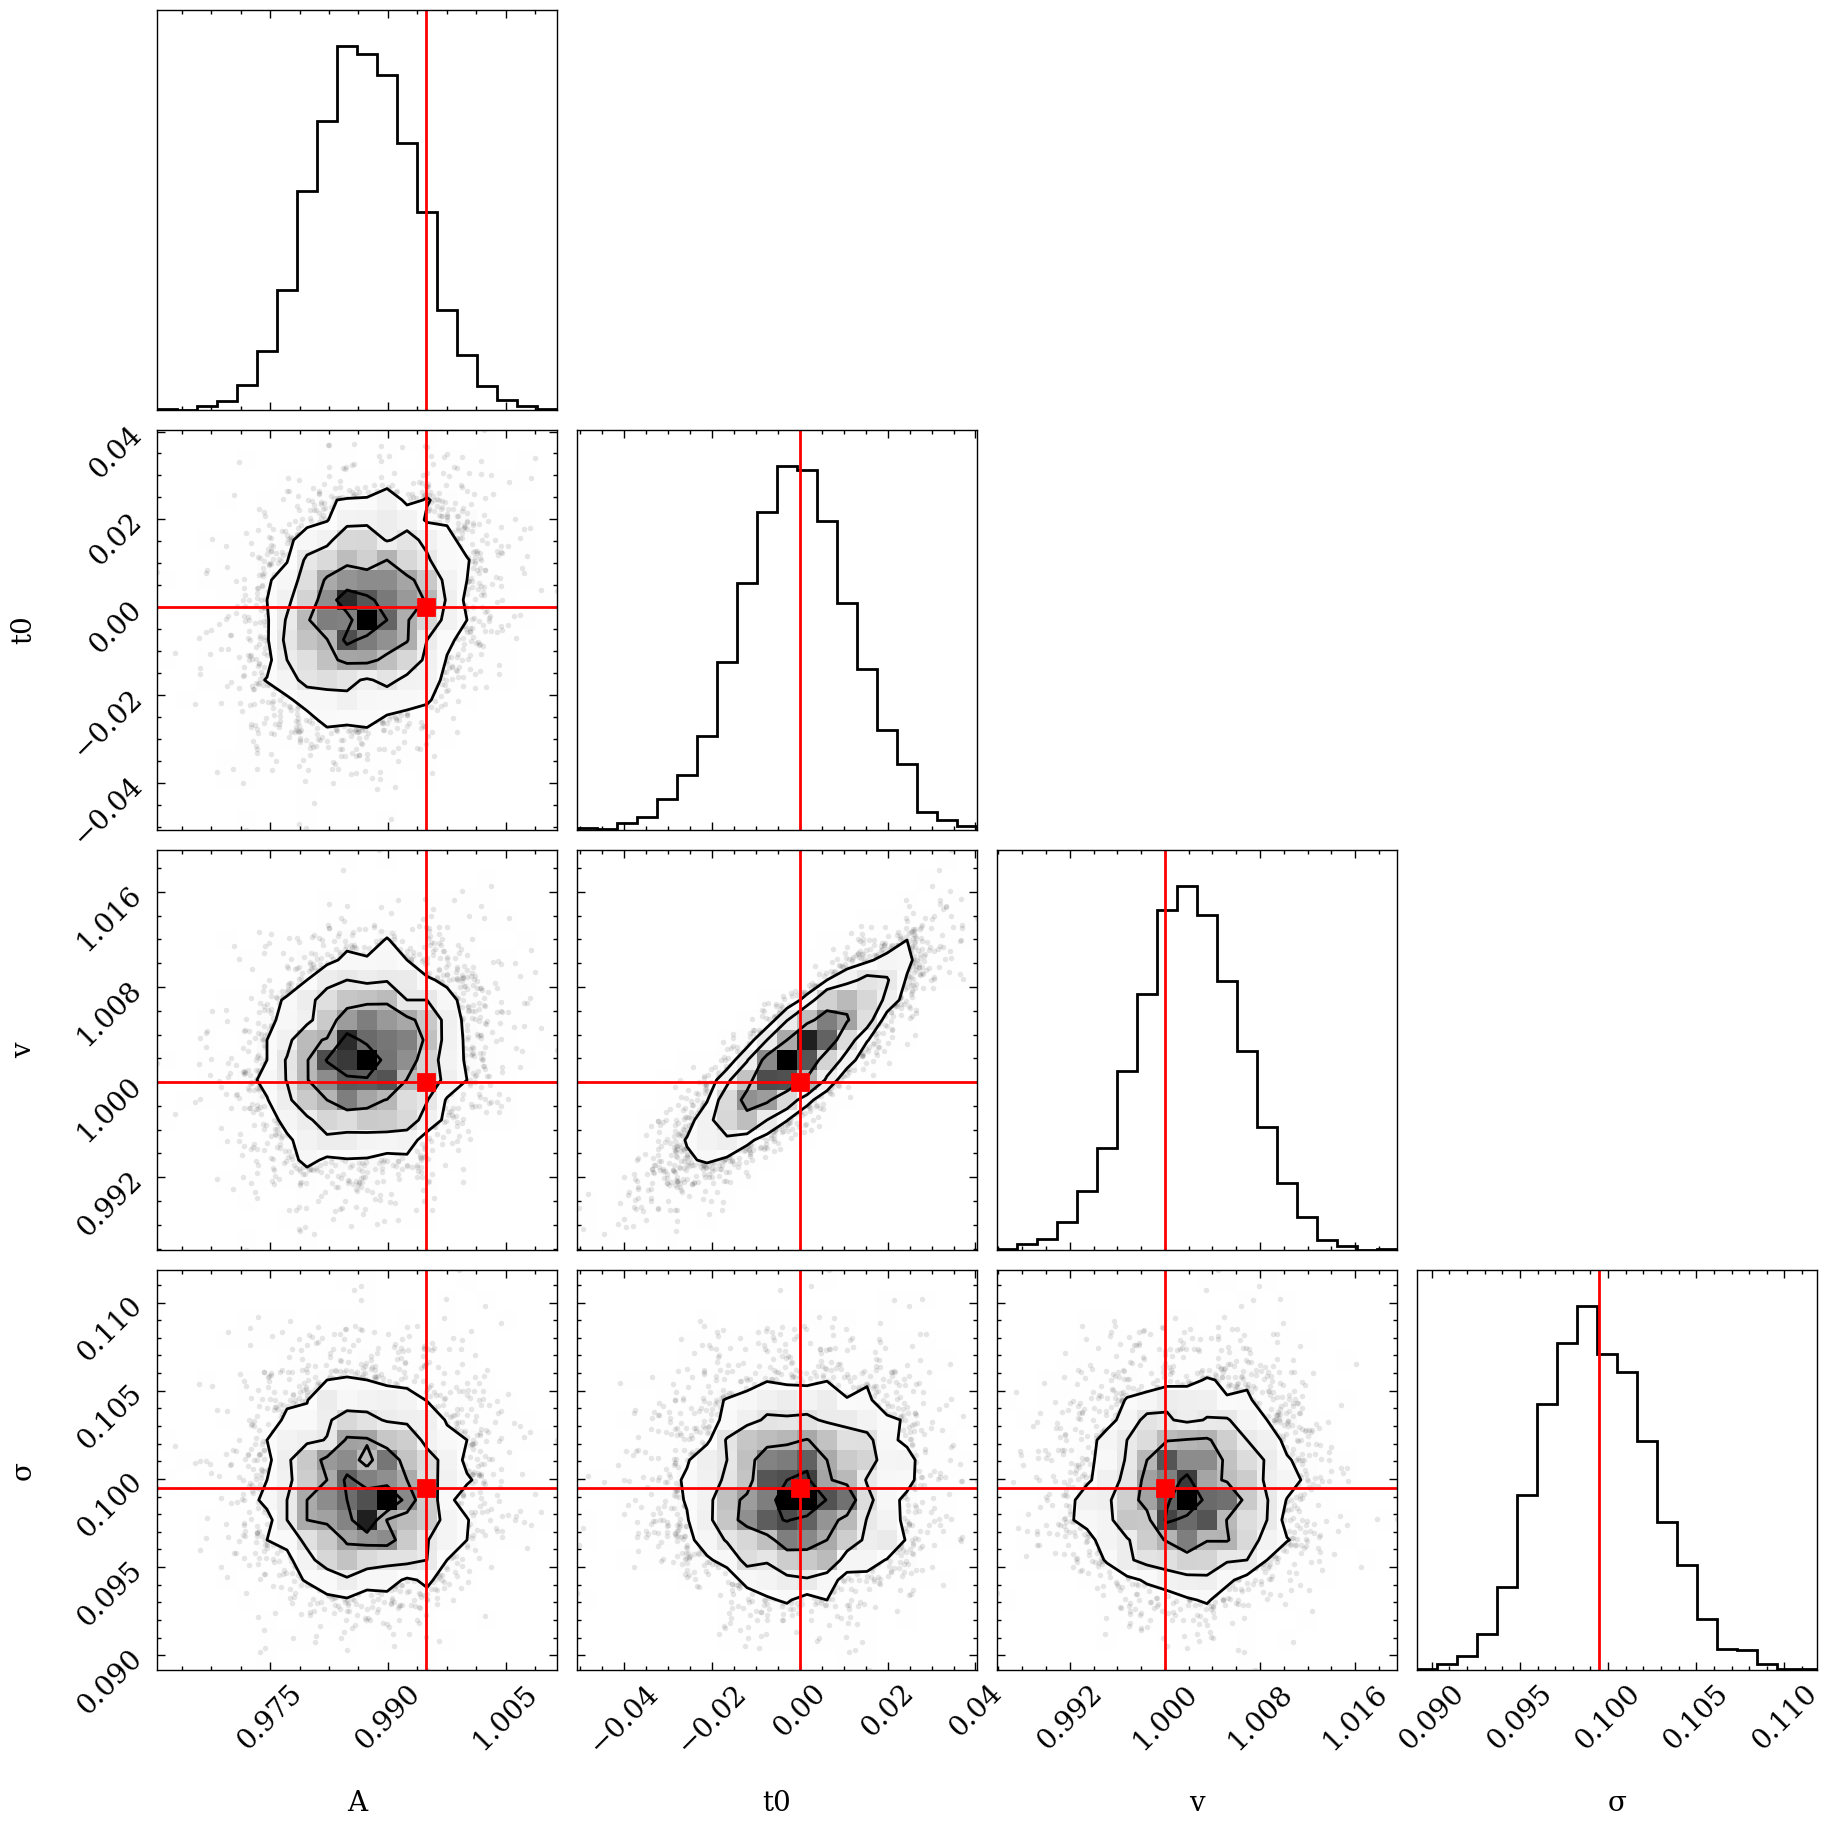

In [18]:
figure = corner.corner(idata, truths=[A_true_scaled, t0_true_scaled, v_true, σ_true_scaled], truth_color='red', divergences=True)

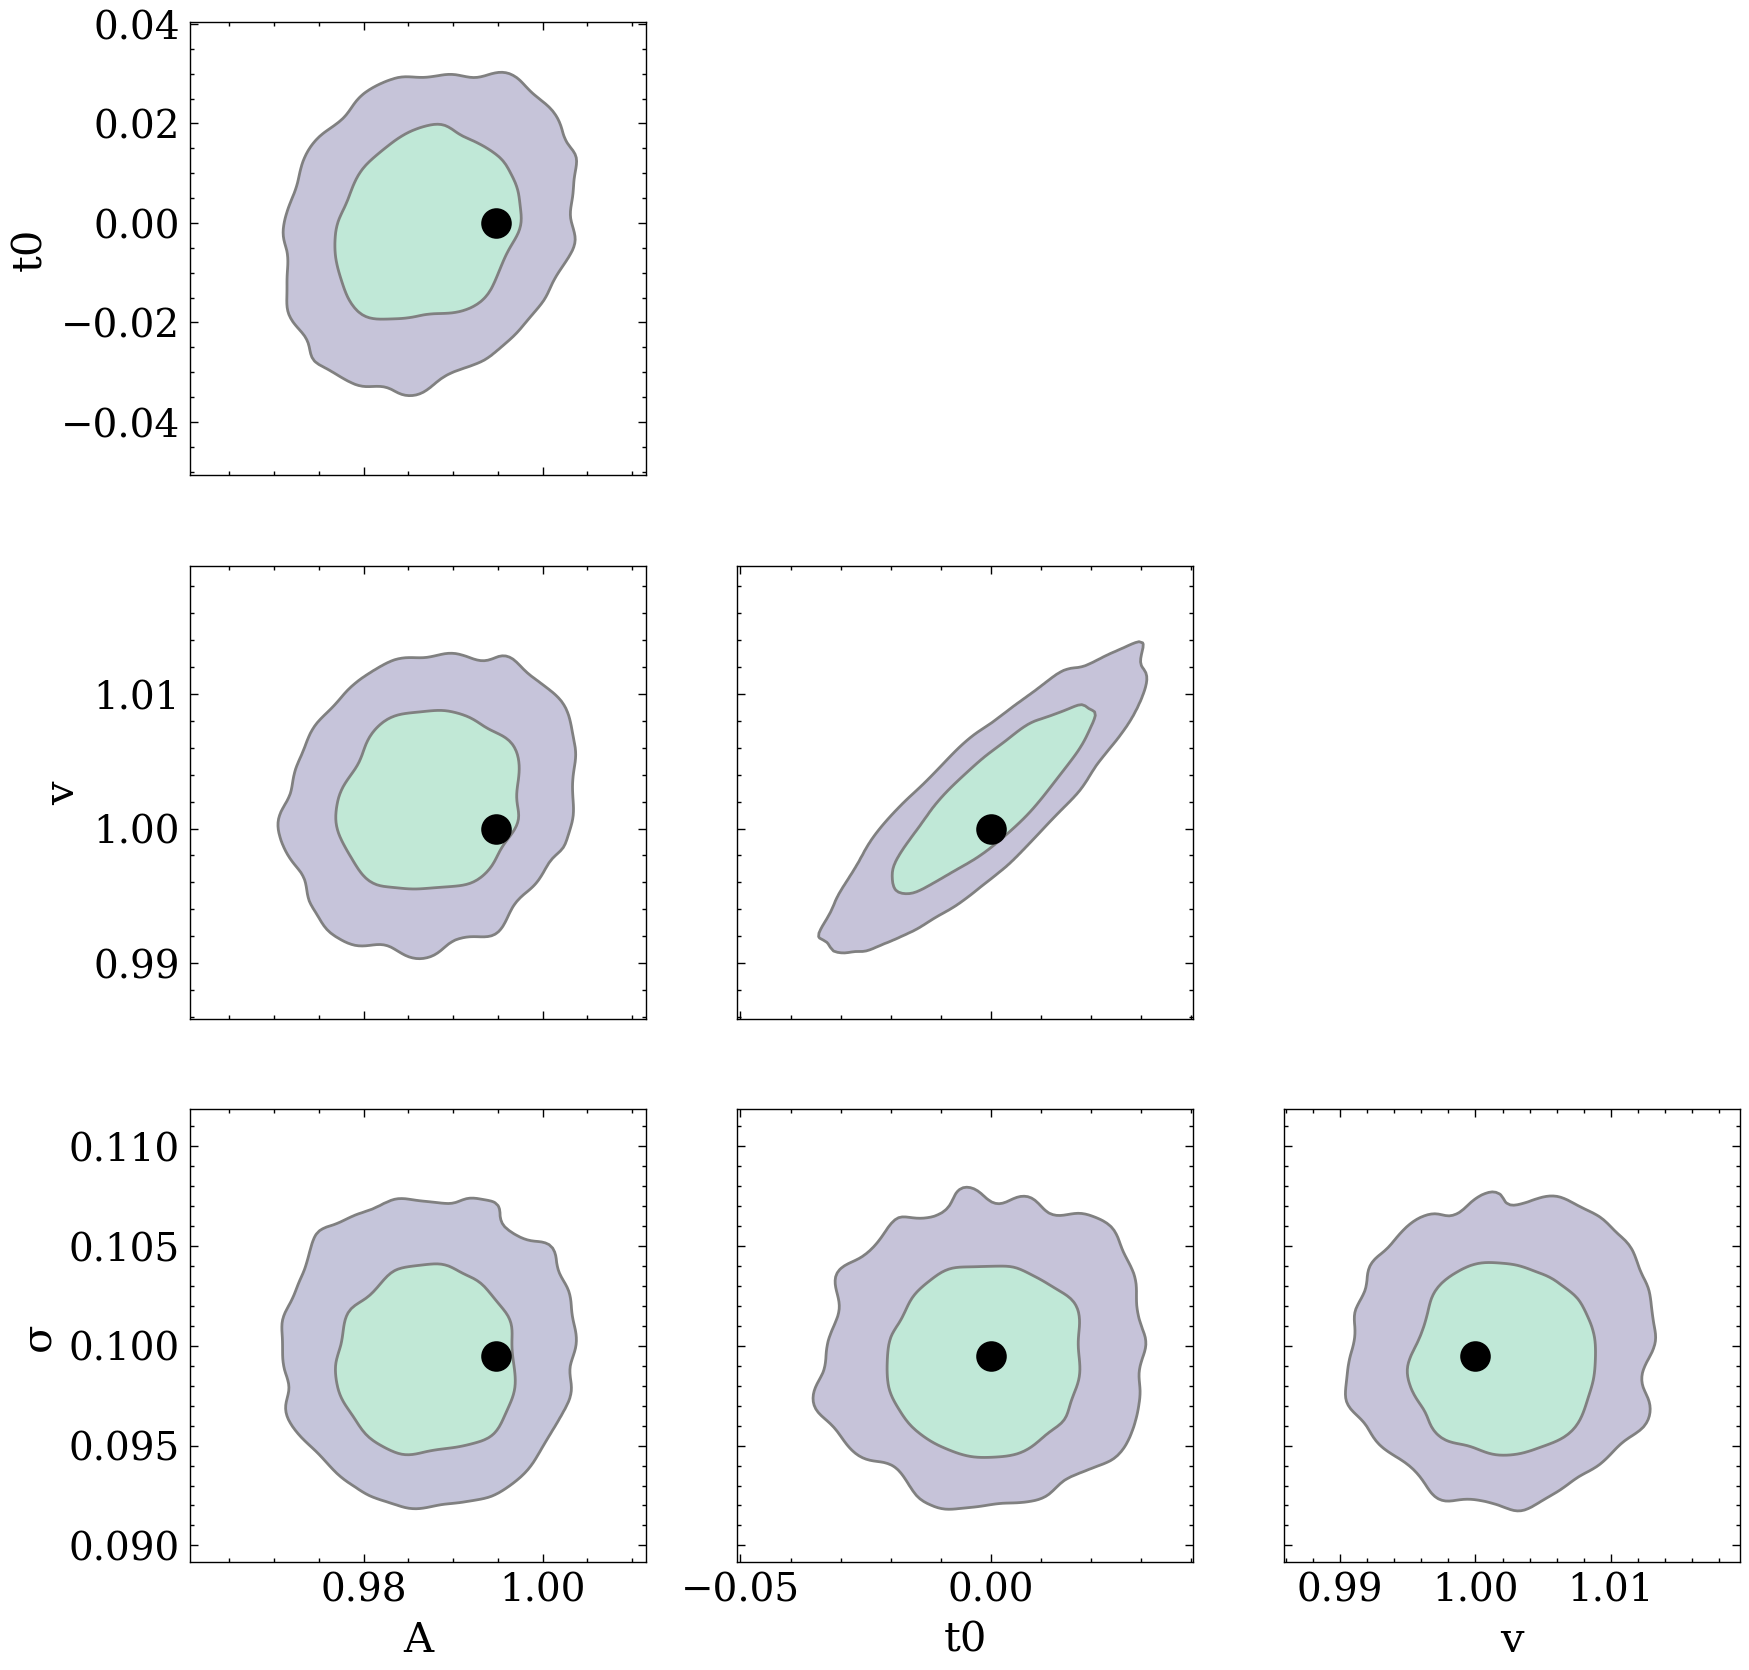

In [19]:
az.plot_pair(
    idata,
    var_names=['A', 't0', 'v', 'σ'],
    kind='kde',
    kde_kwargs={
        "contourf_kwargs": {"alpha": 0.3},
        "hdi_probs": [0.68, 0.95]
    },
    figsize=(10,10),
    divergences=True,
    reference_values={"A":A_true_scaled, "t0": t0_true_scaled, "v": v_true, "σ": σ_true_scaled},
    reference_values_kwargs={"marker": 'o', "ms": 10, "color": "k"},
)
plt.savefig('corner-plot-monokromatik.png')
plt.show()

array([[<AxesSubplot: title={'center': 'A'}>,
        <AxesSubplot: title={'center': 'A'}>],
       [<AxesSubplot: title={'center': 't0'}>,
        <AxesSubplot: title={'center': 't0'}>],
       [<AxesSubplot: title={'center': 'v'}>,
        <AxesSubplot: title={'center': 'v'}>],
       [<AxesSubplot: title={'center': 'σ'}>,
        <AxesSubplot: title={'center': 'σ'}>]], dtype=object)

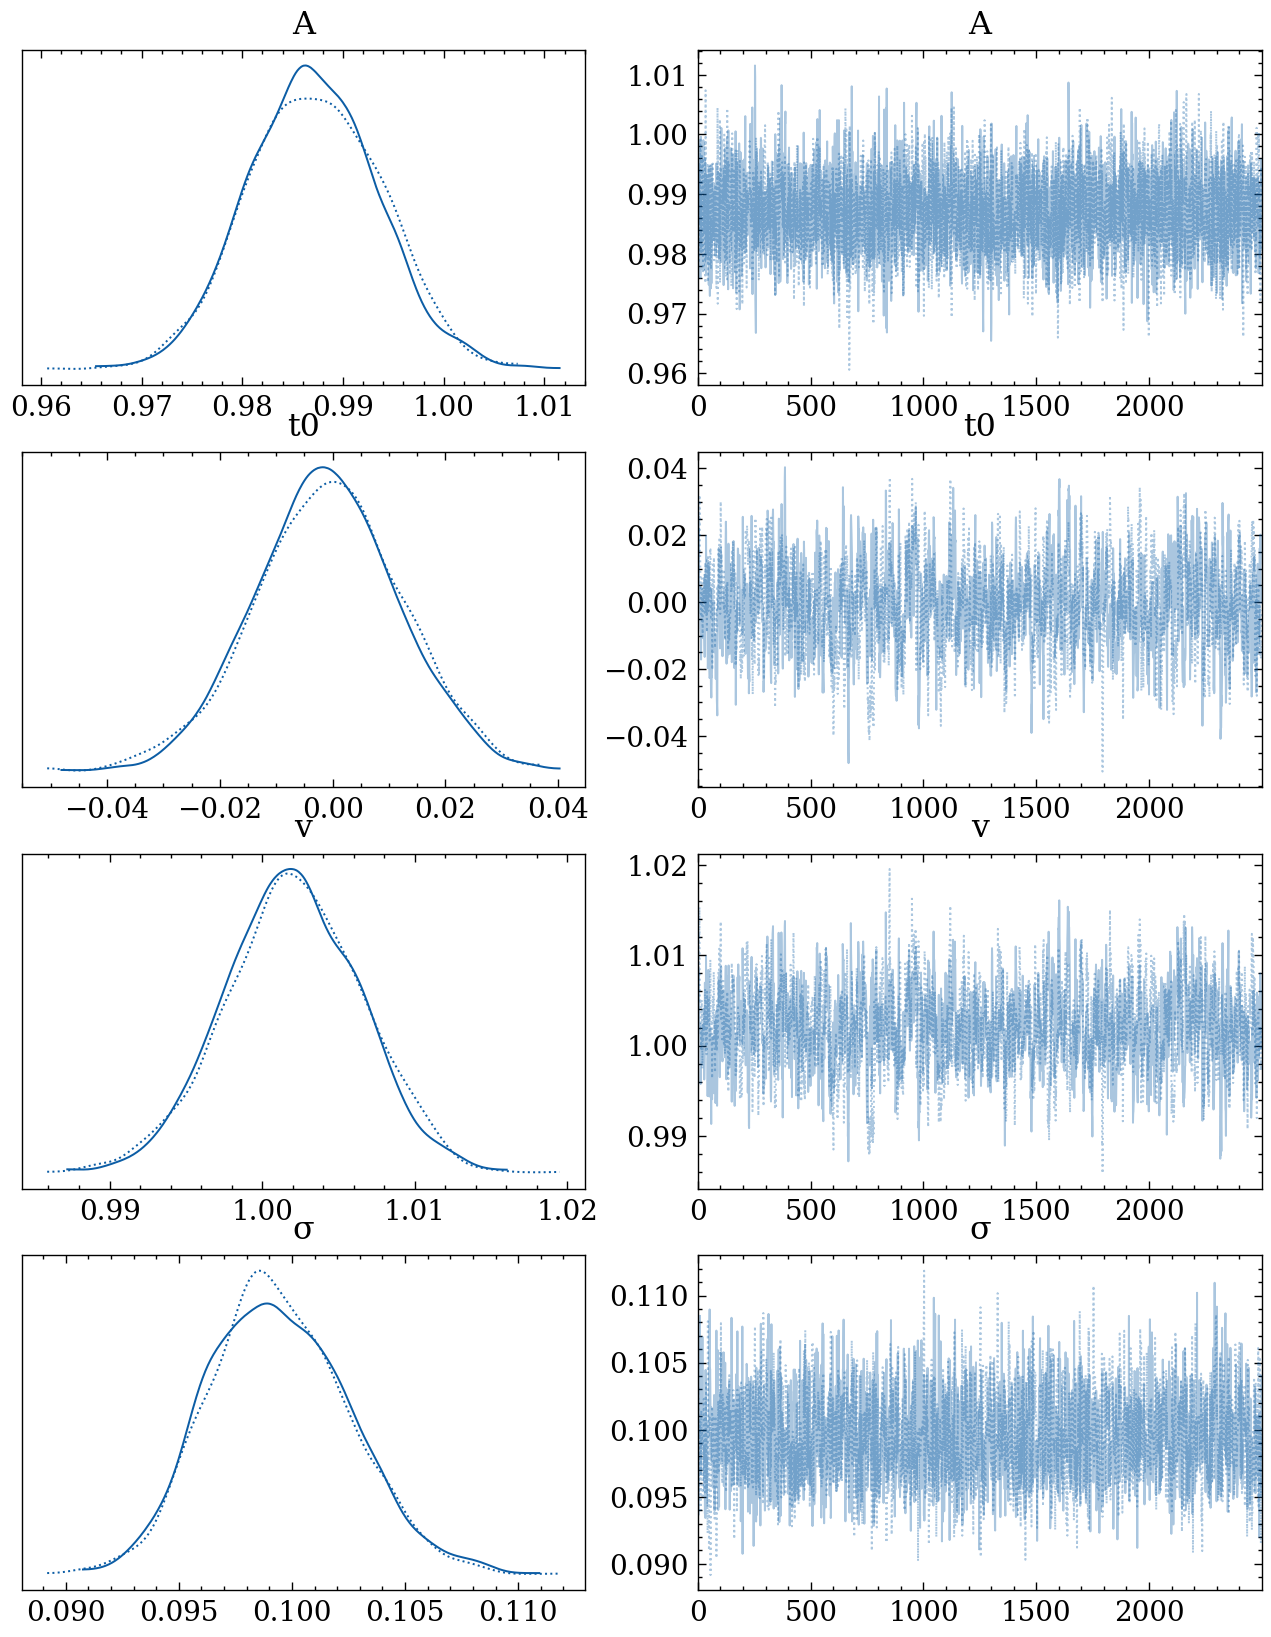

In [20]:
az.plot_trace(idata, figsize=(8,10))

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Feb 09 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.6.0

matplotlib: 3.6.2
aesara    : 2.8.7
corner    : 2.2.1
pandas    : 1.5.1
arviz     : 0.14.0
scipy     : 1.9.3
pymc      : 4.4.0
numpy     : 1.23.5

Watermark: 2.3.1

